In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
from tensorflow.keras import layers, Model
from PIL import Image

In [ ]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 112
CHANNELS = 3

In [ ]:
# Load SSIM scores
ssim_scores = pd.read_csv('ssim_scores_3dmx.csv')
ssim_scores = ssim_scores[['distortion type','image name','ssim score']]

In [ ]:
ssim_scores

,distortion type,image name,ssim score
0,disk_blur,01_01,0.976752
1,disk_blur,01_02,0.938587
2,disk_blur,01_03,0.895730
3,disk_blur,01_04,0.870864
4,disk_blur,01_05,0.850370
...,...,...,...
595,white_gaussian_noise,20_01,0.043506
596,white_gaussian_noise,20_02,0.026293
597,white_gaussian_noise,20_03,0.019792
598,white_gaussian_noise,20_04,0.016470


In [ ]:
base_path = 'images-distorted'

In [ ]:

def load_dataset(base_path, ssim_scores):
    images = []
    labels = []

    for index, row in ssim_scores.iterrows():
        distortion_type = row['distortion type']
        image_name = row['image name']
        ssim_score = row['ssim score']

        folder_path = os.path.join(base_path, distortion_type)
        file_path = os.path.join(folder_path, f"{image_name}.bmp")

        if os.path.exists(file_path):
            img = load_img(file_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(ssim_score)

    return np.array(images), np.array(labels)

In [ ]:
images, labels = load_dataset(base_path, ssim_scores)

In [ ]:
len(images)

600

In [ ]:
def display_non_reference_images(images, labels, num_images=20):
    non_reference_images = [(img, label) for img, label in zip(images, labels) if label != 1.0]
    num_images = min(num_images, len(non_reference_images))
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        img, label = non_reference_images[i]
        plt.subplot(1, num_images, i+1)
        plt.imshow(img.astype("uint8"))
        plt.title(f"Label: {label:.2f}")
        plt.axis('off')
    plt.show()

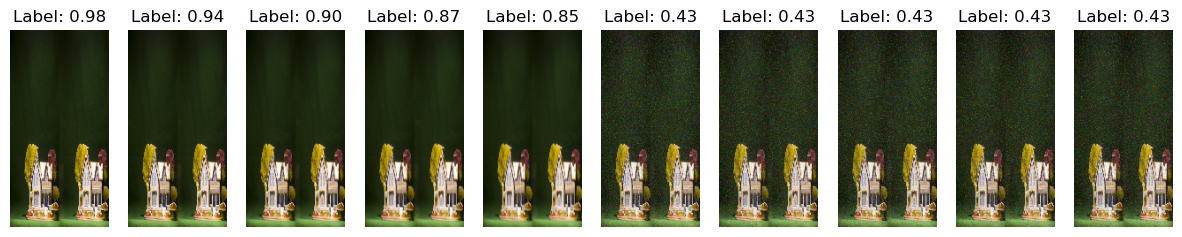

In [ ]:
display_non_reference_images(images, labels, num_images=10)

In [ ]:
width = images[0].shape[0]

In [ ]:
width

224

In [ ]:
def split_images(images):
    left_images = images[:, :, :56, :]
    right_images = images[:,  :,56:, :]
    print(right_images.shape)
    return left_images, right_images

In [ ]:
def display_images(images, num_images=5, title="Images"):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].astype("uint8"))
        plt.axis('off')
    plt.title(title)
    plt.show()

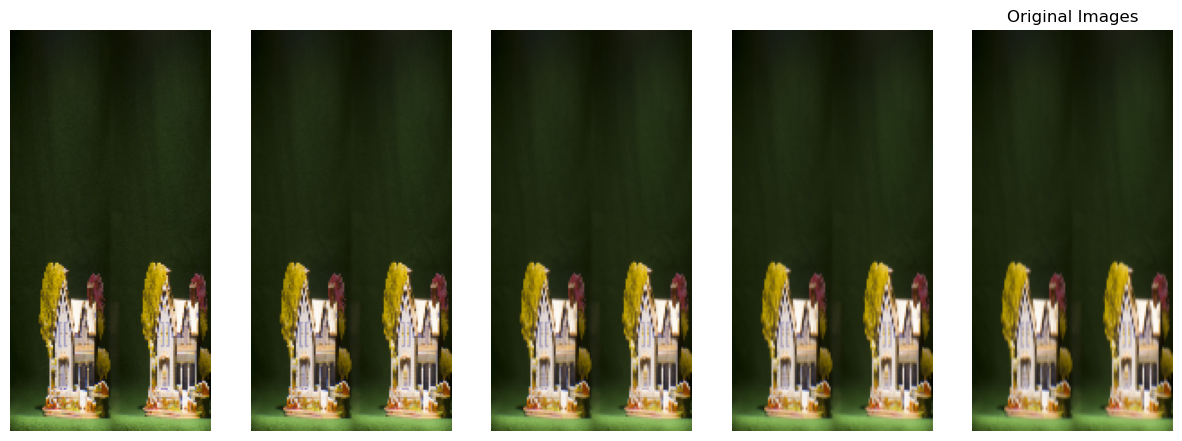

In [ ]:
display_images(images[:5], title="Original Images")

In [ ]:
images[0].size

75264

In [ ]:
# Split images
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=101)

In [ ]:
train_images.shape

(480, 224, 112, 3)

In [ ]:
train_left, train_right = split_images(train_images)
test_left, test_right = split_images(test_images)

(480, 224, 56, 3)
(120, 224, 56, 3)


In [ ]:
train_left.shape

(480, 224, 56, 3)

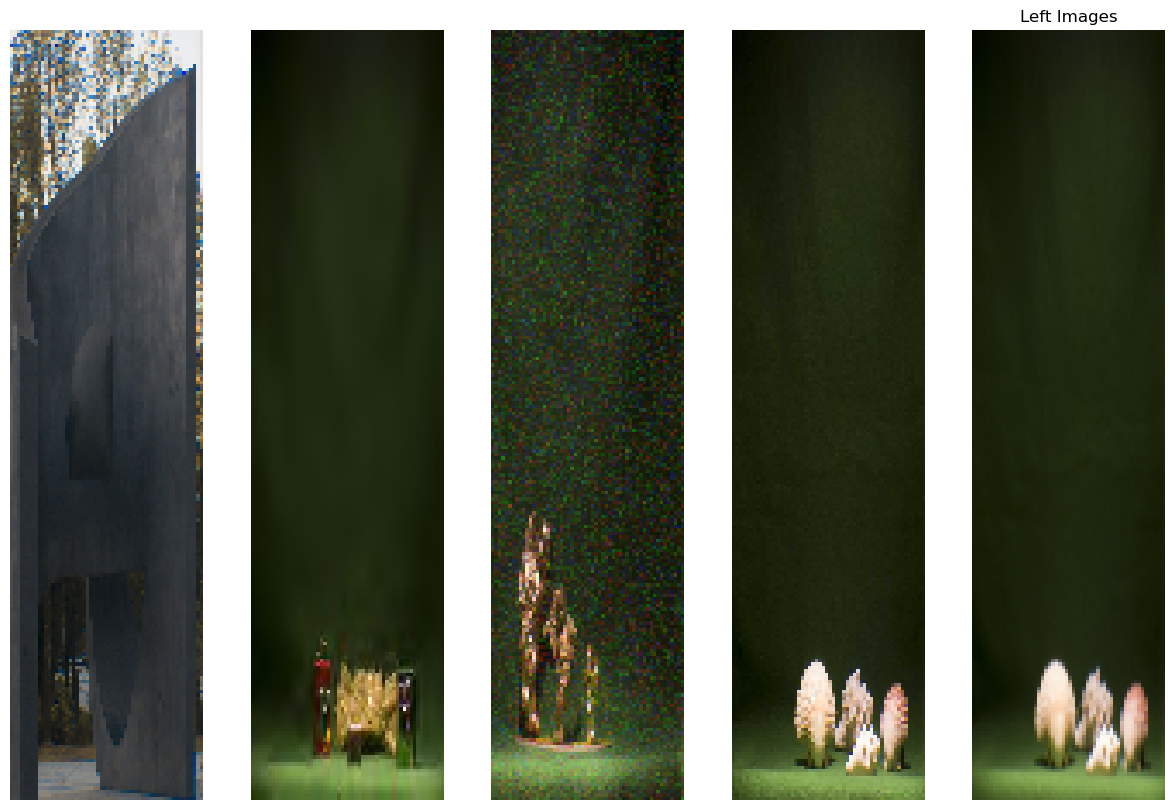

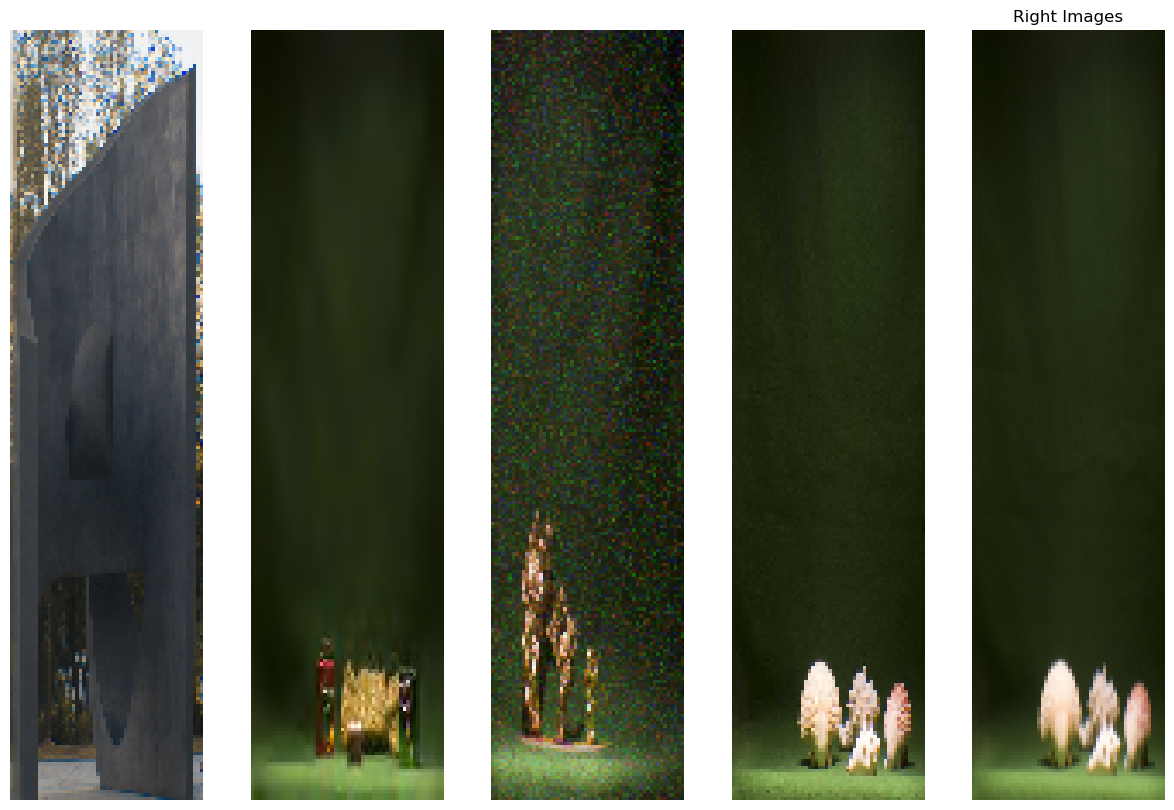

In [ ]:
display_images(train_left[:5], title="Left Images")
display_images(train_right[:5], title="Right Images")

In [ ]:
pip install pywavelets

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pywt

In [ ]:
train_left[0].shape

(224, 56, 3)

In [ ]:
def get_saliency_map_wavelet_rgb(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = gray_image.astype(np.float32)
    height, width = gray_image.shape
    coeffs2 = pywt.dwt2(gray_image, 'haar')
    cA, (cH, cV, cD) = coeffs2
    cH = cv2.resize(cH, (width, height))
    cV = cv2.resize(cV, (width, height))
    cD = cv2.resize(cD, (width, height))
    saliency_map_channel = np.sqrt(cH**2 + cV**2 + cD**2)
    saliency_map = cv2.normalize(saliency_map_channel, None, 0, 255, cv2.NORM_MINMAX)
    return saliency_map.astype(np.uint8)

In [ ]:
salience_train_left = [get_saliency_map_wavelet_rgb(image) for image in train_left]
salience_train_right = [get_saliency_map_wavelet_rgb(image) for image in train_right]

In [ ]:
salience_test_left = [get_saliency_map_wavelet_rgb(image) for image in test_left]
salience_test_right = [get_saliency_map_wavelet_rgb(image) for image in test_right]

In [ ]:
salience_train_left_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(salience_train_left, axis=-1))
salience_train_right_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(salience_train_right, axis=-1))

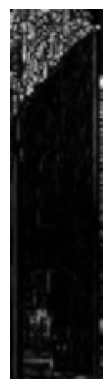

In [ ]:
image_to_display = salience_train_left_rgb[0].numpy() if isinstance(salience_train_left_rgb, tf.Tensor) else salience_train_left_rgb[0]
plt.imshow(image_to_display)
plt.axis('off')
plt.show()

In [ ]:
def display_salience_images(images,window_names=None):
    for i in range(len(images)):
        img = images[i]
        cv2_imshow(img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

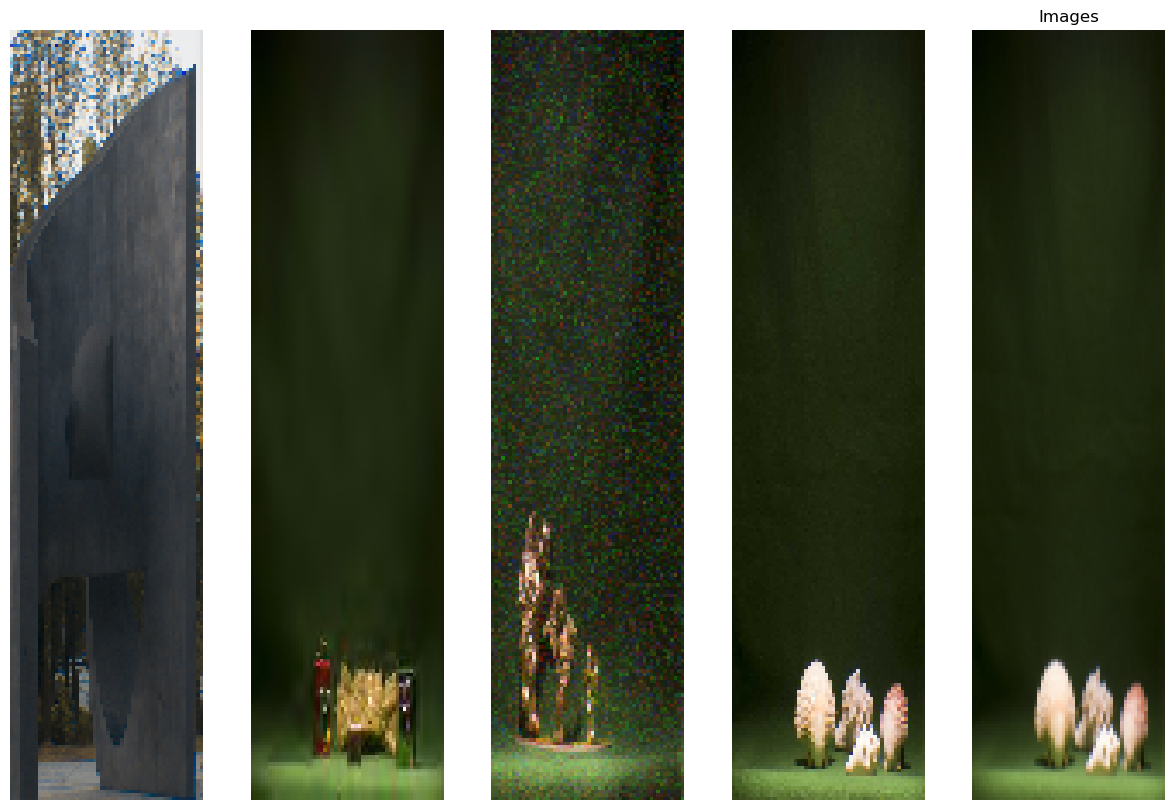

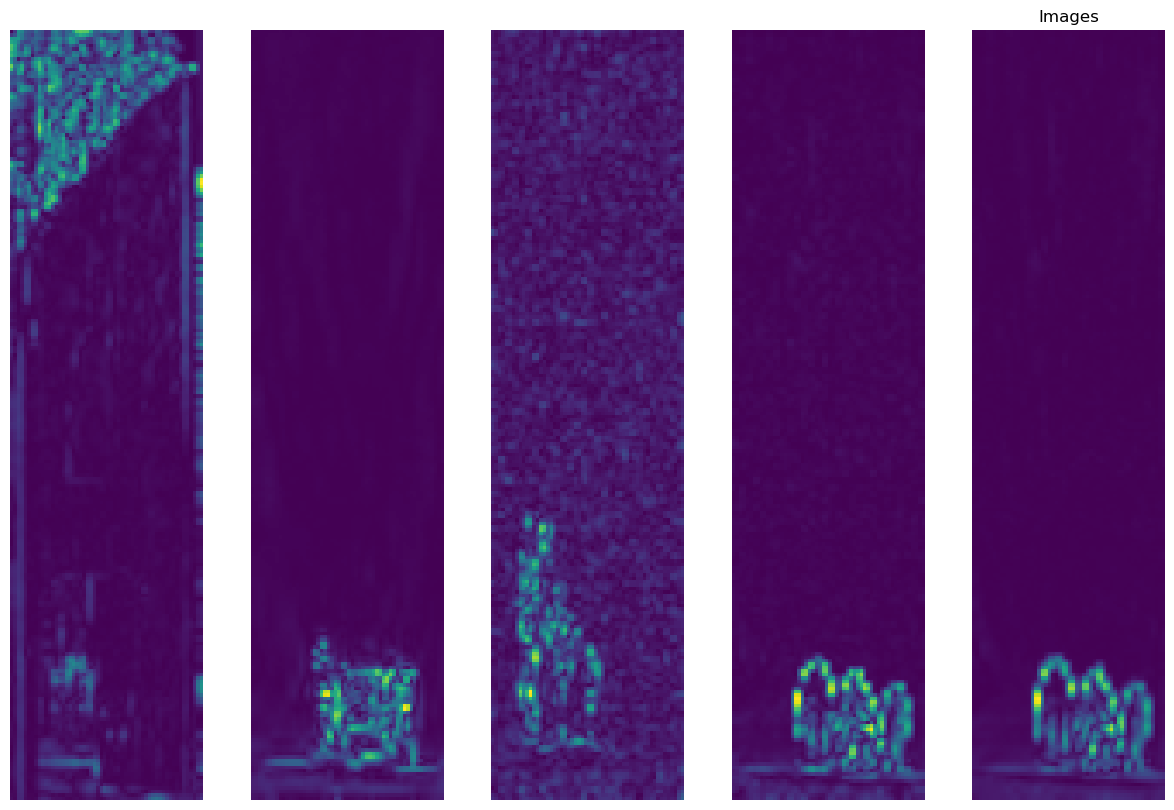

In [ ]:
display_images(train_left[:5])
display_images(salience_train_left[:5])

In [ ]:
input_shape = (224, 56, 3)

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', kernel_initializer='he_uniform')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def build_feature_extractor_with_residuals(input_shape):
    input_layer = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = residual_block(x, 64, stride=2)
    x = residual_block(x, 64, stride=1)
    x = layers.Dropout(0.3)(x)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=1)
    x = layers.Dropout(0.3)(x)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, stride=1)
    x = layers.Dropout(0.4)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    return tf.keras.Model(inputs=input_layer, outputs=x)

In [ ]:
def build_combined_model(left_feature_extractor, right_feature_extractor, input_shape):
    left_input = tf.keras.Input(shape=input_shape)
    right_input = tf.keras.Input(shape=input_shape)

    left_features = left_feature_extractor(left_input)
    right_features = right_feature_extractor(right_input)

    combined_features = layers.concatenate([left_features, right_features])
    combined_features = layers.Dense(1024, activation='relu')(combined_features)
    combined_features = layers.BatchNormalization()(combined_features)
    combined_features = layers.Dropout(0.5)(combined_features)

    combined_features = layers.Dense(512, activation='relu')(combined_features)
    combined_features = layers.BatchNormalization()(combined_features)
    combined_features = layers.Dropout(0.4)(combined_features)

    combined_features = layers.Dense(128, activation='relu')(combined_features)
    combined_features = layers.BatchNormalization()(combined_features)
    combined_features = layers.Dropout(0.3)(combined_features)

    output = layers.Dense(1, activation='sigmoid')(combined_features)

    model = tf.keras.Model(inputs=[left_input, right_input], outputs=output)
    return model

In [ ]:
feature_extractor_left = build_feature_extractor_with_residuals(input_shape)
feature_extractor_right = build_feature_extractor_with_residuals(input_shape)

In [ ]:
combined_model = build_combined_model(feature_extractor_left, feature_extractor_right, input_shape)

In [ ]:
combined_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
combined_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 56,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 224, 56,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 256)       │  2,840,928 │ input_layer_2[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 256)       │  2,840,928 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ functional_1[0][… │
│ (Concatenate)       │                   │            │ functional_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024)      │    525,312 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 1024)      │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    524,800 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        129 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,804,417 (25.96 MB)

 Trainable params: 6,790,849 (25.91 MB)

 Non-trainable params: 13,568 (53.00 KB)

In [ ]:
history = combined_model.fit(
    [salience_train_left_rgb, salience_train_right_rgb],
    train_labels,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - loss: 0.1640 - mae: 0.3154 - val_loss: 0.5821 - val_mae: 0.6710
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - loss: 0.0502 - mae: 0.1435 - val_loss: 0.5821 - val_mae: 0.6710
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - loss: 0.0283 - mae: 0.1131 - val_loss: 0.5821 - val_mae: 0.6710
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - loss: 0.0188 - mae: 0.0931 - val_loss: 0.5821 - val_mae: 0.6710
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - loss: 0.0238 - mae: 0.0994 - val_loss: 0.5795 - val_mae: 0.6695
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - loss: 0.0184 - mae: 0.0942 - val_loss: 0.5092 - val_mae: 0.6055
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - loss: 0.0123 - mae: 0.0756 - val_loss: 0.4030 - val_mae: 0.5032
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - loss: 0.0112 - mae: 0.0725 - val_loss: 0.2325 - val_mae: 0.3355
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 0.0167 - mae: 

In [ ]:
salience_test_left_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(salience_test_left, axis=-1))
salience_test_right_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(salience_test_right, axis=-1))

In [ ]:
test_loss, test_mae = combined_model.evaluate([salience_test_left_rgb, salience_test_right_rgb], test_labels, verbose=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 449ms/step - loss: 0.0108 - mae: 0.0509


In [ ]:
test_predictions = combined_model.predict([salience_test_left_rgb, salience_test_right_rgb])

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step 


In [ ]:
y_true = test_labels.flatten()
y_pred = test_predictions.flatten()

In [ ]:
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau

def calculate_plcc(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

def calculate_srocc(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]

def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def calculate_krocc(y_true, y_pred):
    return kendalltau(y_true, y_pred)[0]

In [ ]:
plcc_score = calculate_plcc(y_true, y_pred)
srocc_score = calculate_srocc(y_true, y_pred)
rmse_score = calculate_rmse(y_true, y_pred)
krocc_score = calculate_krocc(y_true, y_pred)

In [ ]:
print(f'PLCC: {plcc_score}')
print(f'SROCC: {srocc_score}')
print(f'RMSE: {rmse_score}')
print(f'KROCC: {krocc_score}')

PLCC: 0.9743006475309531
SROCC: 0.8109035349677061
RMSE: 0.08958383910246168
KROCC: 0.6442577030812324


In [ ]:
test_image_names = [f"{int(i/5)+1:02d}_{i%5+1:02d}" for i in range(len(test_images))]
test_distortions = ssim_scores.loc[ssim_scores['image name'].isin(test_image_names)]
distortion_types = test_distortions['distortion type'].unique()
results = {}

for distortion in distortion_types:
    indices = test_distortions[test_distortions['distortion type'] == distortion].index.tolist()
    valid_indices = [idx for idx in indices if idx < len(salience_test_left_rgb)]
    distortion_test_left_rgb = tf.gather(salience_test_left_rgb, valid_indices)
    distortion_test_right_rgb = tf.gather(salience_test_right_rgb, valid_indices)
    distortion_test_labels = tf.gather(test_labels, valid_indices)
    predictions = combined_model.predict([distortion_test_left_rgb, distortion_test_right_rgb])
    plcc = np.corrcoef(predictions.flatten(), distortion_test_labels.numpy().flatten())[0, 1]
    srocc = np.corrcoef(np.argsort(predictions.flatten()), np.argsort(distortion_test_labels.numpy().flatten()))[0, 1]
    rmse = np.sqrt(np.mean((predictions.flatten() - distortion_test_labels.numpy().flatten())**2))
    krocc = np.corrcoef(np.argsort(np.argsort(predictions.flatten())), np.argsort(np.argsort(distortion_test_labels.numpy().flatten())))[0, 1]
    results[distortion] = {
        'PLCC': plcc,
        'SROCC': srocc,
        'RMSE': rmse,
        'KROCC': krocc
    }
for distortion, metrics in results.items():
    print(f"Distortion type: {distortion}")
    print(f"PLCC: {metrics['PLCC']}")
    print(f"SROCC: {metrics['SROCC']}")
    print(f"RMSE: {metrics['RMSE']}")
    print(f"KROCC: {metrics['KROCC']}")
    print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Distortion type: disk_blur
PLCC: 0.9941854673045993
SROCC: 0.2150375939849624
RMSE: 0.04254557031604138
KROCC: 0.8466165413533834

Distortion type: fast_fading
PLCC: 0.9531507224107592
SROCC: -0.3744360902255639
RMSE: 0.10765197765953294
KROCC: 0.7263157894736841

Distortion type: gaussian_blur
PLCC: 0.9499027225377341
SROCC: 0.11578947368421053
RMSE: 0.12368594882807199
KROCC: 0.7954887218045112

Distortion type: jpeg
PLCC: 0.9899530187677976
SROCC: 0.4526315789473684
RMSE: 0.056721245675055314
KROCC: 0.9052631578947368

Distortion type: jpeg2k
PLCC: 0.981707052523339
SROCC: 0.26165413533834586
RMSE: 0.08438741932559804
KROCC: 0.9248120300751879

Distortion type: white_gaussian_noise
PLCC: 0.9732073655678789
SROCC: 0.19248120300751878
RMSE: 0.095476499397